In [6]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import os
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from tensorflow.keras.optimizers import Adam
from sklearn.linear_model import LinearRegression

In [7]:
# Functions for image loading and preprocessing
def load_and_preprocess_image(image_path, size=(224, 224)):
    with Image.open(image_path) as img:
        img = img.resize(size)
        img_array = np.array(img) / 255.0  # Normalize to [0, 1]
    return img_array

# Load training data
train_data_path = 'train.csv'
train_data = pd.read_csv(train_data_path)
train_image_folder = 'train'
train_image_paths = [os.path.join(train_image_folder, f"{image_id}.jpg") for image_id in train_data['Id']]

# Initialize ResNet50 for feature extraction
base_model = ResNet50(weights='imagenet', include_top=False)
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='linear')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers except the top ones
for layer in base_model.layers:
    layer.trainable = False

# Compiling the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')

# Data augmentation generator
data_gen = ImageDataGenerator(rotation_range=20,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              shear_range=0.2,
                              zoom_range=0.2,
                              horizontal_flip=True,
                              fill_mode='nearest')

# Batch processing function
def process_images_in_batches(image_paths, batch_size=32):
    num_batches = len(image_paths) // batch_size + 1
    all_features = []

    for i in range(num_batches):
        batch_paths = image_paths[i*batch_size:(i+1)*batch_size]
        batch_images = np.array([load_and_preprocess_image(path) for path in batch_paths])
        batch_features = model.predict(batch_images)
        all_features.append(batch_features)
    
    # Convert list of batches to a single numpy array
    return np.concatenate(all_features, axis=0)

# Process images in batches and ensure features are 2D
train_features = process_images_in_batches(train_image_paths)

# Scaling and PCA
scaler = StandardScaler()
pca = PCA(n_components=0.95)

# Flatten train_features if it's not already 2D
train_features_flattened = train_features.reshape(train_features.shape[0], -1)

scaled_features = scaler.fit_transform(train_features_flattened)
pca_features = pca.fit_transform(scaled_features)

# Clustering
kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(pca_features)
train_data['Cluster'] = clusters

# Train a linear regressor for each cluster
cluster_models = {}
for cluster in np.unique(clusters):
    cluster_indices = np.where(clusters == cluster)[0]
    cluster_x = pca_features[cluster_indices]
    cluster_y = train_data.loc[cluster_indices, 'Pawpularity']
    lr = LinearRegression()
    lr.fit(cluster_x, cluster_y)
    cluster_models[cluster] = lr

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 882ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step
1/1 ━━━

In [12]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

silhouette_avg = silhouette_score(pca_features, clusters)
calinski_harabasz = calinski_harabasz_score(pca_features, clusters)
davies_bouldin = davies_bouldin_score(pca_features, clusters)

print(f"Silhouette Score: {silhouette_avg}")
print(f"Calinski-Harabasz Score: {calinski_harabasz}")
print(f"Davies-Bouldin Score: {davies_bouldin}")


Silhouette Score: 0.5271145105361938
Calinski-Harabasz Score: 29405.706647517545
Davies-Bouldin Score: 0.5400182935045641


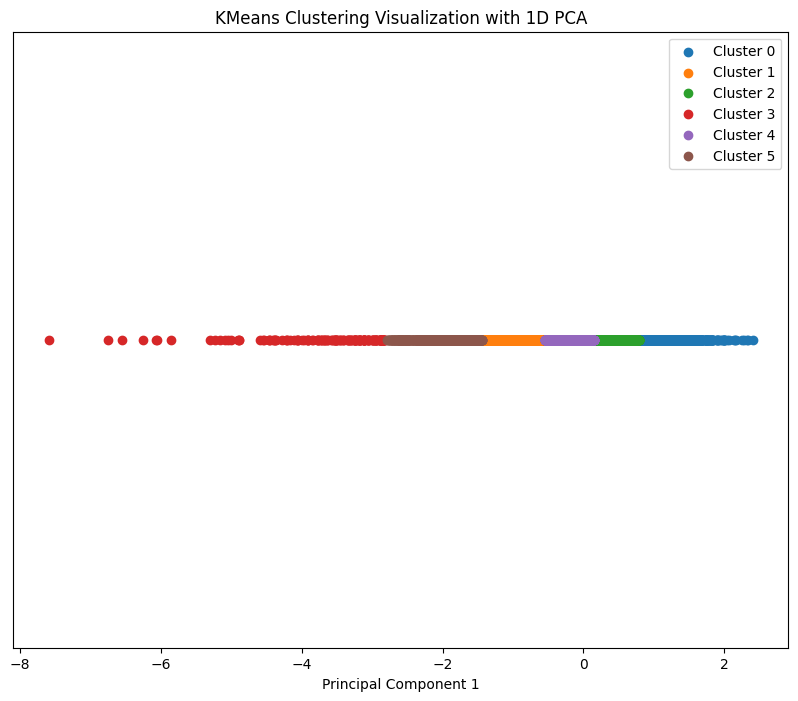

In [23]:
plt.figure(figsize=(10, 8))
for cluster in np.unique(clusters):
    plt.scatter(pca_features[clusters == cluster, 0], np.zeros(sum(clusters == cluster)), label=f'Cluster {cluster}')
plt.xlabel('Principal Component 1')
plt.title('KMeans Clustering Visualization with 1D PCA')
plt.yticks([])  # Remove y-ticks as they are not informative
plt.legend()
plt.show()


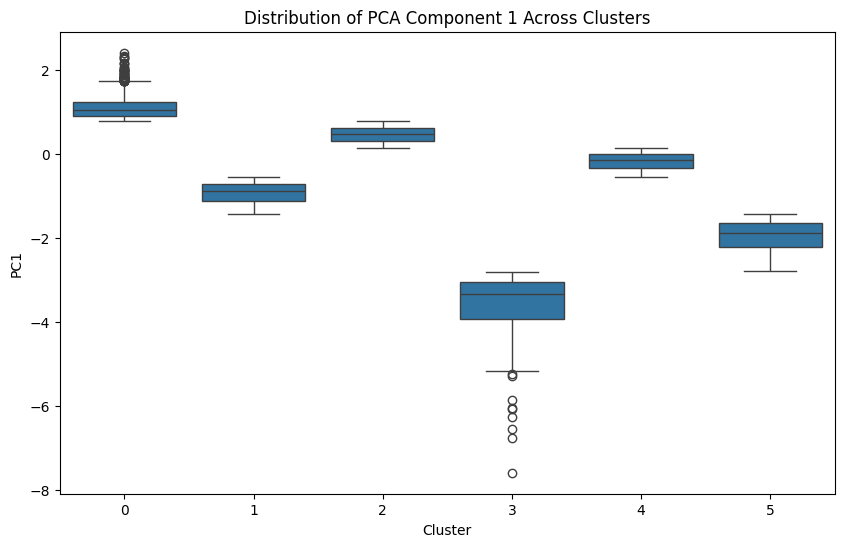

In [17]:
import seaborn as sns

# Create a DataFrame for easier plotting
cluster_df = pd.DataFrame(pca_features, columns=['PC1'])
cluster_df['Cluster'] = clusters

plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='PC1', data=cluster_df)
plt.title('Distribution of PCA Component 1 Across Clusters')
plt.show()


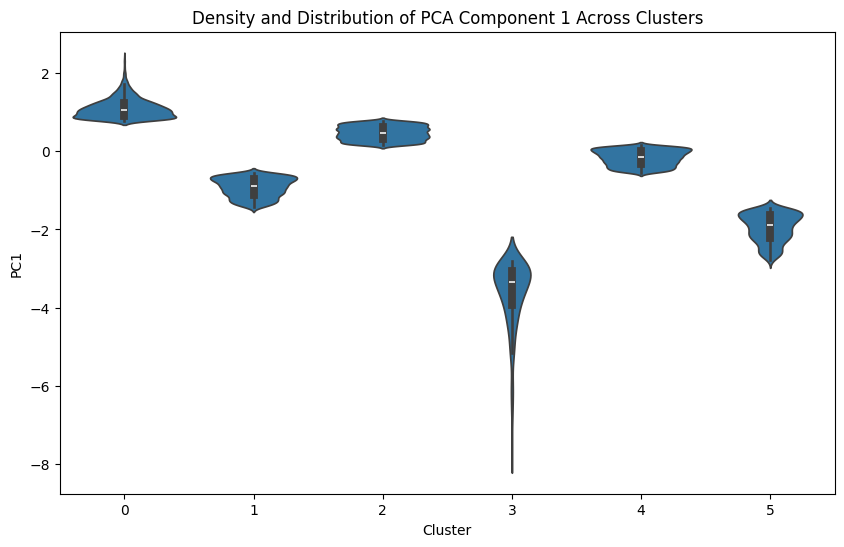

In [18]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Cluster', y='PC1', data=cluster_df)
plt.title('Density and Distribution of PCA Component 1 Across Clusters')
plt.show()


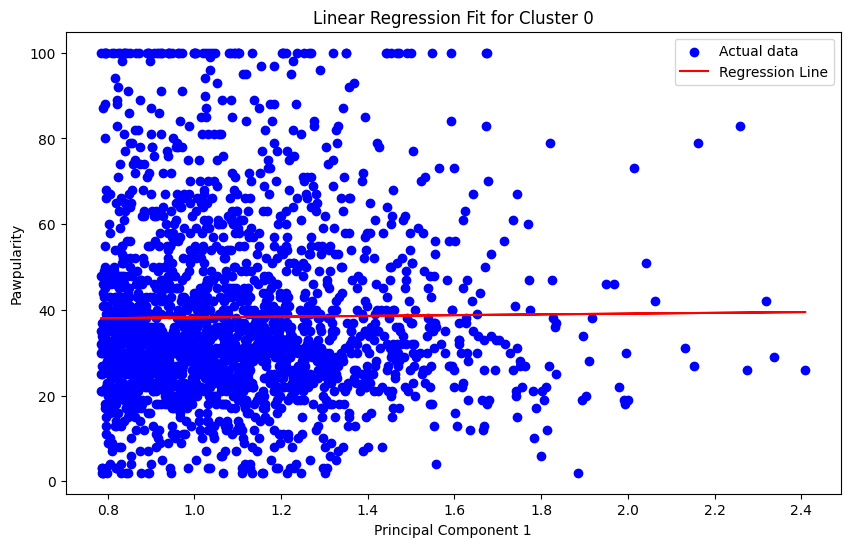

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Example for one cluster
cluster_id = 0
cluster_indices = np.where(clusters == cluster_id)[0]
cluster_x = pca_features[cluster_indices, 0]  # Assuming only one PCA component
cluster_y = train_data.loc[cluster_indices, 'Pawpularity']

# Fit and predictions
lr = LinearRegression()
lr.fit(cluster_x.reshape(-1, 1), cluster_y)
predictions = lr.predict(cluster_x.reshape(-1, 1))

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(cluster_x, cluster_y, color='blue', label='Actual data')
plt.plot(cluster_x, predictions, color='red', label='Regression Line')
plt.title(f'Linear Regression Fit for Cluster {cluster_id}')
plt.xlabel('Principal Component 1')
plt.ylabel('Pawpularity')
plt.legend()
plt.show()


In [8]:
from tensorflow.keras.models import Model
from sklearn.linear_model import LinearRegression
import joblib
import numpy as np

# Assume `model` is your fine-tuned ResNet50 model
# Assume `cluster_models` is a dictionary where keys are cluster numbers and values are LinearRegression models

# Save the fine-tuned ResNet50 model
model.save('fine_tuned_resnet50.keras')

# Save each linear regression model for clusters
for cluster, lr_model in cluster_models.items():
    joblib.dump(lr_model, f'cluster_model_{cluster}.pkl')

print("Models have been saved successfully.")


Models have been saved successfully.


In [11]:
from tensorflow.keras.models import load_model
import joblib
import numpy as np
import pandas as pd
import os
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# Load test data
test_data_path = 'test.csv'
test_data = pd.read_csv(test_data_path)
test_image_folder = 'test'
test_image_paths = [os.path.join(test_image_folder, f"{image_id}.jpg") for image_id in test_data['Id']]

# Load the fine-tuned ResNet50 model
model = load_model('fine_tuned_resnet50.keras')

# Load each linear regression model for clusters
cluster_models = {}
for cluster in range(6):  # Assuming you used 6 clusters
    cluster_models[cluster] = joblib.load(f'cluster_model_{cluster}.pkl')

# Function to load and preprocess a test image
def load_and_preprocess_image(image_path, size=(224, 224)):
    with Image.open(image_path) as img:
        img = img.resize(size)
        img_array = np.array(img) / 255.0  # Normalize to [0, 1]
    return img_array

# Process images in batches and ensure features are 2D
def process_images_in_batches(image_paths, batch_size=32):
    num_batches = len(image_paths) // batch_size + 1
    all_features = []

    for i in range(num_batches):
        batch_paths = image_paths[i*batch_size:(i+1)*batch_size]
        batch_images = np.array([load_and_preprocess_image(path) for path in batch_paths])
        batch_features = model.predict(batch_images)
        all_features.append(batch_features)
    
    # Convert list of batches to a single numpy array
    return np.concatenate(all_features, axis=0)

# Process test images in batches
test_features = process_images_in_batches(test_image_paths)

# Load the scaler and PCA model that were used during training
scaler = StandardScaler()
pca = PCA(n_components=0.95)

# Flatten test_features if it's not already 2D
test_features_flattened = test_features.reshape(test_features.shape[0], -1)

# Scale and apply PCA
scaled_test_features = scaler.fit_transform(test_features_flattened)
pca_test_features = pca.fit_transform(scaled_test_features)

# Predict the clusters for the test data
kmeans = KMeans(n_clusters=6, random_state=42)
test_clusters = kmeans.fit_predict(pca_test_features)

# Predict Pawpularity scores
predictions = np.zeros(len(test_data))
for cluster in np.unique(test_clusters):
    cluster_indices = np.where(test_clusters == cluster)[0]
    cluster_x = pca_test_features[cluster_indices]
    lr_model = cluster_models[cluster]
    predictions[cluster_indices] = lr_model.predict(cluster_x)

# Add the predictions to the test_data DataFrame
test_data['Pawpularity'] = predictions

# Ensure the CSV file contains only the 'Id' and 'Pawpularity' columns
output = test_data[['Id', 'Pawpularity']]

# Save the predictions to a CSV file with the correct format
output.to_csv('test_predictions.csv', index=False)

print("Predictions have been made and saved successfully in the format 'Id,Pawpularity'.")

c:\Users\btuud\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 6 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predictions have been made and saved successfully in the format 'Id,Pawpularity'.


In [30]:
import sklearn
print(sklearn.__version__)


1.5.1
